PROGRAM PREDIKSI STUNTING PADA BALITA - DECISION TREE CLASSIFIER

LANGKAH 1: MEMUAT DATA
Data berhasil dimuat dengan 70076 baris dan 7 kolom.
Kolom yang tersedia: ['Umur (bulan)', 'Tinggi Badan', 'Jenis Kelamin Encoded', 'Status Gizi Encoded', 'Jenis Kelamin', 'Status Gizi', 'Kategori Umur']

LANGKAH 2: EKSPLORASI DATA AWAL
Shape data: (70076, 7)

Info data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70076 entries, 0 to 70075
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Umur (bulan)           70076 non-null  int64  
 1   Tinggi Badan           70076 non-null  float64
 2   Jenis Kelamin Encoded  70076 non-null  int64  
 3   Status Gizi Encoded    70076 non-null  int64  
 4   Jenis Kelamin          70076 non-null  object 
 5   Status Gizi            70076 non-null  object 
 6   Kategori Umur          70076 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 3.7+ MB
N

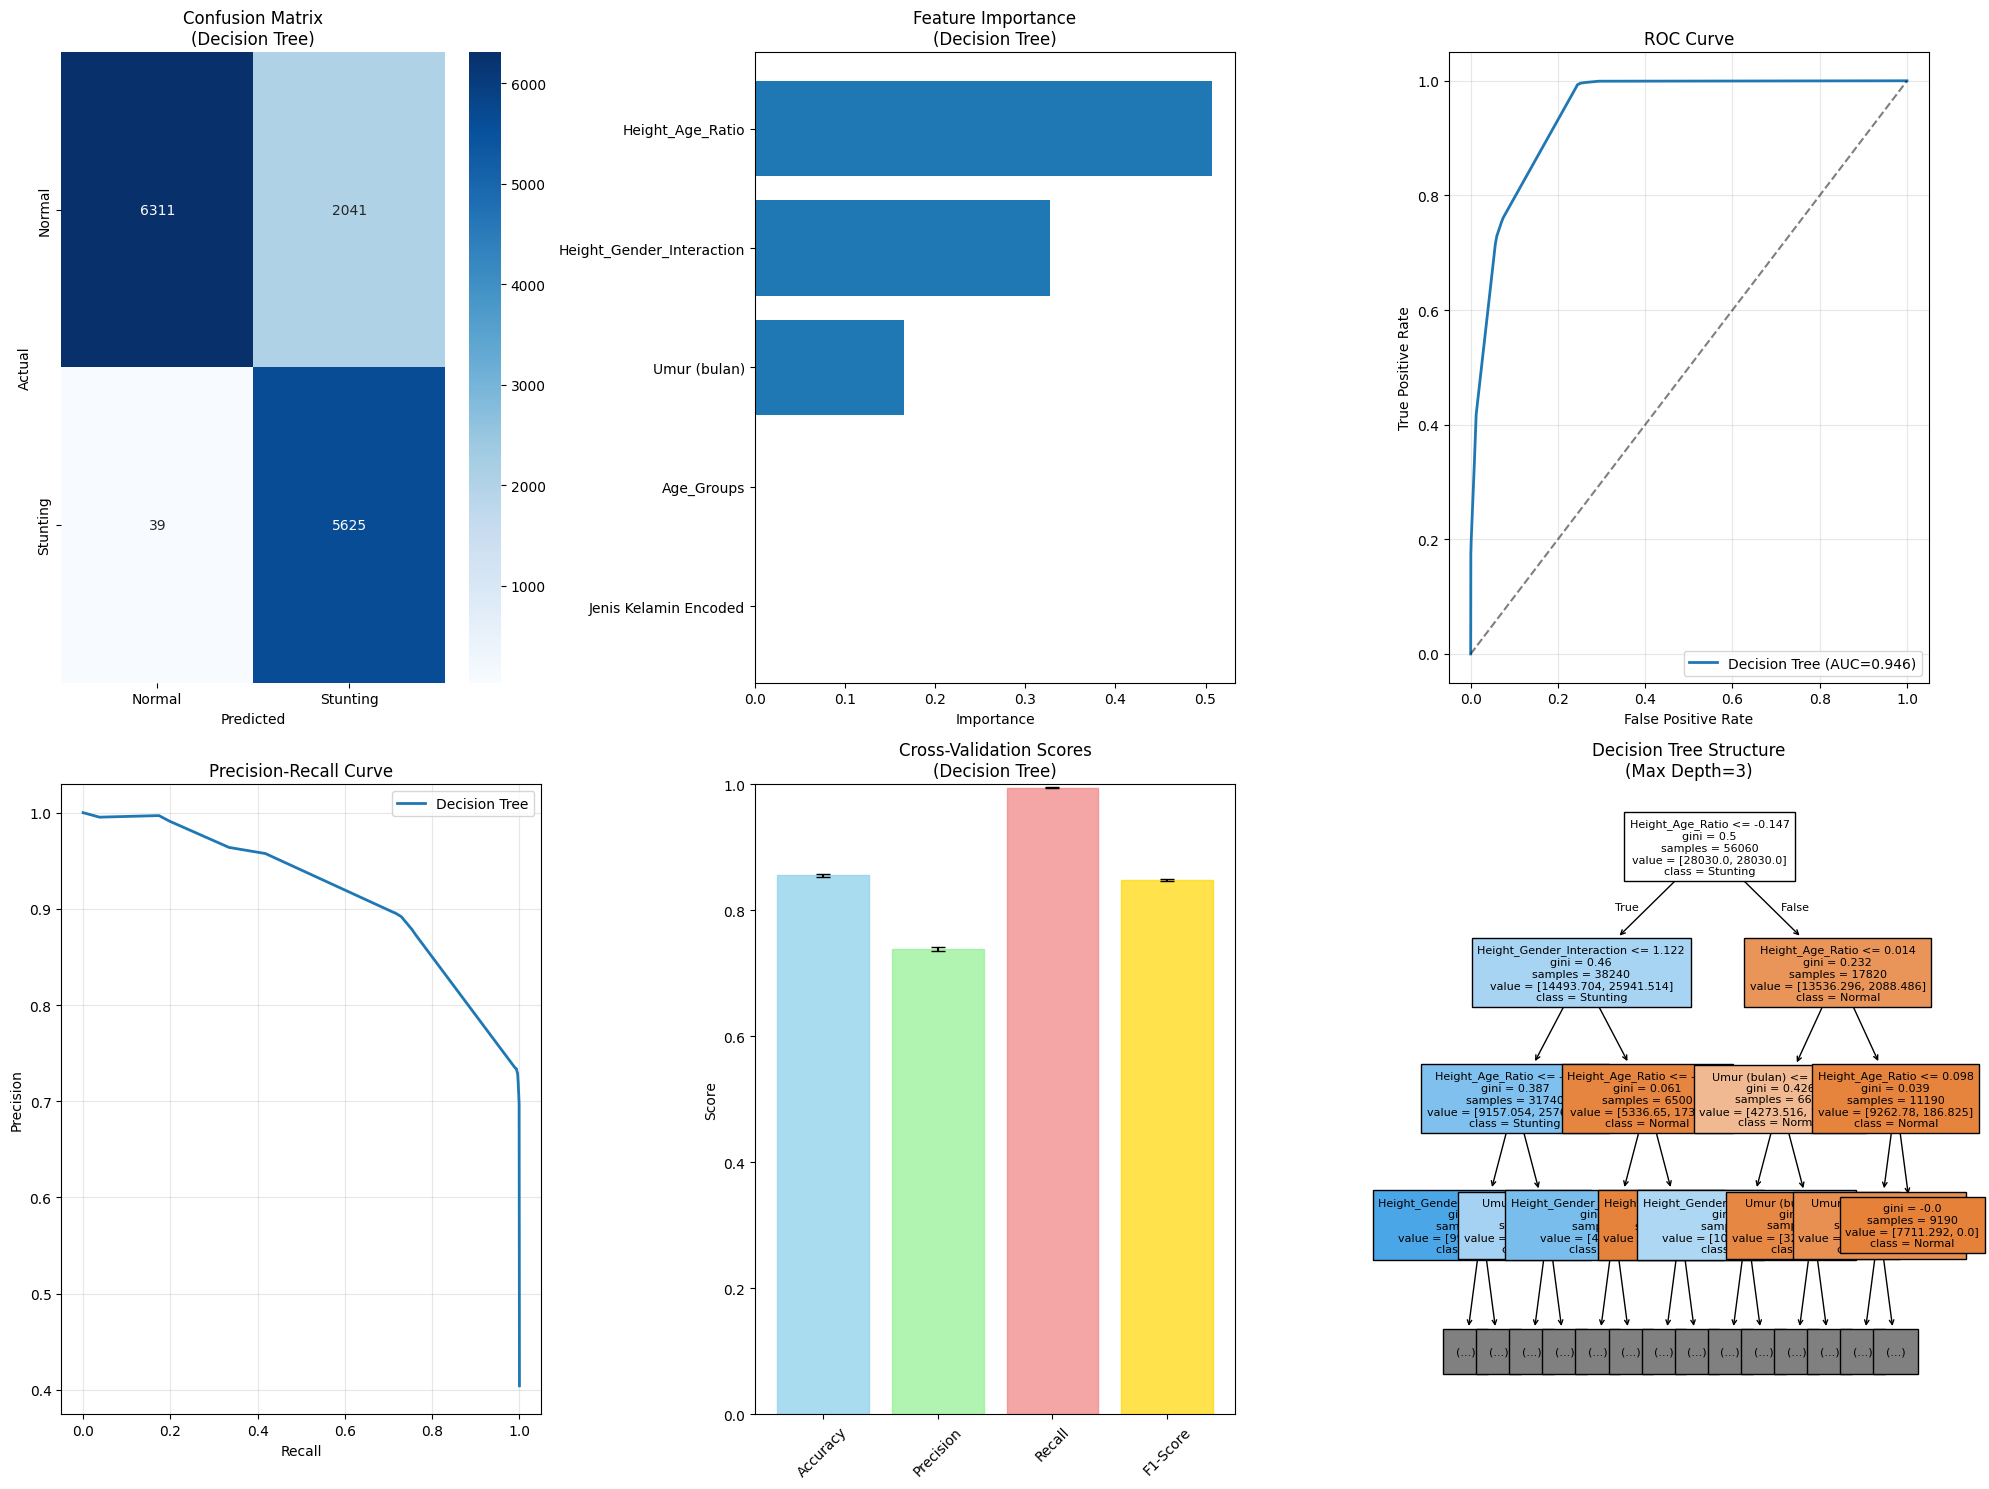

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           precision_score, recall_score, f1_score, roc_auc_score, 
                           roc_curve, precision_recall_curve)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils.class_weight import compute_class_weight
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("PROGRAM PREDIKSI STUNTING PADA BALITA - DECISION TREE CLASSIFIER")
print("="*70)

# 1. LOAD DATA
print("\nLANGKAH 1: MEMUAT DATA")
try:
    data = pd.read_csv('data_balita_preprocessed.csv')
    print(f"Data berhasil dimuat dengan {data.shape[0]} baris dan {data.shape[1]} kolom.")
    print(f"Kolom yang tersedia: {list(data.columns)}")
    
    # Pastikan data memiliki kolom yang diperlukan
    required_columns = ['Umur (bulan)', 'Tinggi Badan', 'Jenis Kelamin']
    missing_columns = [col for col in required_columns if col not in data.columns]
    
    if missing_columns:
        print(f"Kolom yang hilang: {missing_columns}")
        # Coba cari kolom alternatif
        if 'Jenis Kelamin' not in data.columns and 'Jenis Kelamin Encoded' in data.columns:
            # Decode jenis kelamin dari encoded
            data['Jenis Kelamin'] = data['Jenis Kelamin Encoded'].map({0: 'laki-laki', 1: 'perempuan'})
            print("Kolom 'Jenis Kelamin' dibuat dari 'Jenis Kelamin Encoded'")
    
except FileNotFoundError:
    print("File 'data_balita_preprocessed.csv' tidak ditemukan.")
    print("Membuat data sintetis untuk demonstrasi...")
    
    # Buat data sintetis yang realistis
    np.random.seed(42)
    n_samples = 1000
    
    data = pd.DataFrame({
        'Umur (bulan)': np.random.randint(6, 60, n_samples),  # 6-60 bulan
        'Tinggi Badan': np.random.normal(85, 15, n_samples),  # cm
        'Jenis Kelamin': np.random.choice(['laki-laki', 'perempuan'], n_samples),
    })
    
    # Pastikan tinggi badan positif dan realistis
    data['Tinggi Badan'] = np.clip(data['Tinggi Badan'], 45, 120)

# 2. EKSPLORASI DATA AWAL
print("\nLANGKAH 2: EKSPLORASI DATA AWAL")
print(f"Shape data: {data.shape}")
print(f"\nInfo data:")
print(data.info())
print(f"\nStatistik deskriptif:")
print(data.describe())

# 3. PEMBUATAN TARGET STUNTING TANPA DATA LEAKAGE
print("\nLANGKAH 3: PEMBUATAN TARGET STUNTING BERDASARKAN STANDAR WHO")

def calculate_stunting_who_based(age_months, height_cm, gender):
    """
    Menghitung status stunting berdasarkan standar WHO
    Menggunakan pendekatan z-score height-for-age
    """
    # Normalisasi nama gender
    gender = str(gender).lower()
    if gender in ['laki-laki', 'male', 'l', 'm', '0']:
        gender_key = 'Laki-laki'
    elif gender in ['perempuan', 'female', 'p', 'f', '1']:
        gender_key = 'Perempuan'
    else:
        gender_key = 'Laki-laki'  # default
    
    # Referensi tinggi median berdasarkan umur dan jenis kelamin (WHO 2006)
    # Data ini adalah approximation - dalam implementasi nyata gunakan tabel WHO lengkap
    who_height_ref = {
        'Laki-laki': {
            6: 67.6, 12: 75.7, 18: 82.3, 24: 87.1, 30: 91.9,
            36: 96.1, 42: 99.9, 48: 103.3, 54: 106.4, 60: 109.4
        },
        'Perempuan': {
            6: 65.7, 12: 74.0, 18: 80.7, 24: 85.7, 30: 90.3,
            36: 94.1, 42: 97.4, 48: 100.3, 54: 103.0, 60: 105.6
        }
    }
    
    # Standar deviasi approximation
    std_dev = 4.0  # WHO standard deviation approximation
    
    # Interpolasi untuk umur yang tidak tepat
    if gender_key in who_height_ref:
        ages = sorted(who_height_ref[gender_key].keys())
        heights = [who_height_ref[gender_key][age] for age in ages]
        
        # Clamp age to available range
        age_months = max(min(age_months, max(ages)), min(ages))
        
        # Linear interpolation
        expected_height = np.interp(age_months, ages, heights)
        
        # Hitung z-score
        z_score = (height_cm - expected_height) / std_dev
        
        # Stunting jika z-score < -2 (standar WHO)
        return 1 if z_score < -2 else 0
    
    return 0  # Default tidak stunting jika data tidak lengkap

# Encode jenis kelamin jika belum ada
if 'Jenis Kelamin Encoded' not in data.columns:
    le_gender = LabelEncoder()
    data['Jenis Kelamin Encoded'] = le_gender.fit_transform(data['Jenis Kelamin'])
    print("Jenis Kelamin berhasil di-encode")

# Buat target stunting berdasarkan WHO
print("Menghitung status stunting berdasarkan standar WHO...")
stunting_status = []

for idx, row in data.iterrows():
    age = row['Umur (bulan)']
    height = row['Tinggi Badan']
    gender = row['Jenis Kelamin']
    
    stunting = calculate_stunting_who_based(age, height, gender)
    stunting_status.append(stunting)

data['Is_Stunting'] = stunting_status

# Periksa distribusi target
print(f"\nDistribusi target stunting:")
stunting_counts = data['Is_Stunting'].value_counts()
print(f"Normal (0): {stunting_counts.get(0, 0)} ({stunting_counts.get(0, 0)/len(data)*100:.1f}%)")
print(f"Stunting (1): {stunting_counts.get(1, 0)} ({stunting_counts.get(1, 0)/len(data)*100:.1f}%)")

# Validasi distribusi
if stunting_counts.get(1, 0) == 0:
    print("\nTIDAK ADA KASUS STUNTING TERDETEKSI - MENYESUAIKAN THRESHOLD...")
    # Gunakan persentil 20% terendah sebagai stunting untuk demo
    height_threshold = data['Tinggi Badan'].quantile(0.2)
    data['Is_Stunting'] = (data['Tinggi Badan'] <= height_threshold).astype(int)
    
    stunting_counts = data['Is_Stunting'].value_counts()
    print(f"Setelah penyesuaian:")
    print(f"Normal (0): {stunting_counts.get(0, 0)} ({stunting_counts.get(0, 0)/len(data)*100:.1f}%)")
    print(f"Stunting (1): {stunting_counts.get(1, 0)} ({stunting_counts.get(1, 0)/len(data)*100:.1f}%)")

# 4. FEATURE ENGINEERING (TANPA DATA LEAKAGE)
print("\nLANGKAH 4: FEATURE ENGINEERING")

# Buat fitur tambahan berdasarkan data yang tersedia
print("Membuat fitur tambahan...")

# Hitung BMI jika ada berat badan, jika tidak gunakan proporsi tinggi/umur
if 'Berat Badan' in data.columns:
    data['BMI'] = data['Berat Badan'] / ((data['Tinggi Badan']/100) ** 2)
    print("BMI berhasil dihitung dari Berat Badan dan Tinggi Badan")
else:
    # Buat proxy BMI dari tinggi badan dan umur
    data['Height_Age_Ratio'] = data['Tinggi Badan'] / data['Umur (bulan)']
    print("Height-Age Ratio dibuat sebagai proxy BMI")

# Kategorisasi umur
data['Age_Groups'] = pd.cut(data['Umur (bulan)'], 
                           bins=[0, 12, 24, 36, 60], 
                           labels=[0, 1, 2, 3])
data['Age_Groups'] = data['Age_Groups'].astype(int)

# Buat fitur interaksi
data['Height_Gender_Interaction'] = data['Tinggi Badan'] * data['Jenis Kelamin Encoded']

# Pilih fitur yang tersedia untuk model
available_features = []

# Fitur dasar yang selalu ada
basic_features = ['Umur (bulan)', 'Jenis Kelamin Encoded', 'Age_Groups', 'Height_Gender_Interaction']
available_features.extend(basic_features)

# Tambahkan fitur berdasarkan ketersediaan kolom
if 'BMI' in data.columns:
    available_features.append('BMI')
if 'Height_Age_Ratio' in data.columns:
    available_features.append('Height_Age_Ratio')

# Cek dan tambahkan kolom sosio-ekonomi jika ada
socio_economic_features = ['Pendidikan Ibu', 'Pendapatan Keluarga', 'ASI Eksklusif', 
                          'Imunisasi Lengkap', 'Riwayat Penyakit', 'Akses Air Bersih']

for feat in socio_economic_features:
    if feat in data.columns:
        # Encode categorical variables
        le = LabelEncoder()
        encoded_col = f'{feat}_Encoded'
        data[encoded_col] = le.fit_transform(data[feat])
        available_features.append(encoded_col)
        print(f"Fitur {feat} berhasil di-encode")

print(f"Fitur yang akan digunakan: {available_features}")

# Persiapkan data
X = data[available_features].copy()
y = data['Is_Stunting'].copy()

# Handle missing values
X = X.fillna(X.median())

print(f"Shape fitur: {X.shape}")
print(f"Missing values: {X.isnull().sum().sum()}")

# 5. SPLIT DATA DENGAN STRATIFIKASI
print("\nLANGKAH 5: MEMBAGI DATA")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data latih: {X_train.shape[0]} sampel")
print(f"Data uji: {X_test.shape[0]} sampel")
print(f"Distribusi kelas latih: Normal={sum(y_train==0)}, Stunting={sum(y_train==1)}")
print(f"Distribusi kelas uji: Normal={sum(y_test==0)}, Stunting={sum(y_test==1)}")

# 6. FEATURE SCALING
print("\nLANGKAH 6: SCALING FITUR")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. FEATURE SELECTION
print("\nLANGKAH 7: FEATURE SELECTION")

# Gunakan SelectKBest untuk memilih fitur terbaik
selector = SelectKBest(score_func=f_classif, k=min(6, X_train.shape[1]))
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

selected_features = X.columns[selector.get_support()]
print(f"Fitur terpilih: {list(selected_features)}")

# 8. INISIALISASI MODEL DECISION TREE
print("\nLANGKAH 8: INISIALISASI MODEL DECISION TREE")

model = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',
    max_depth=6,
    min_samples_split=20,
    min_samples_leaf=10,
    criterion='gini'  # bisa juga 'entropy'
)

print("Model Decision Tree berhasil diinisialisasi dengan parameter:")
print(f"  - Max depth: {model.max_depth}")
print(f"  - Min samples split: {model.min_samples_split}")
print(f"  - Min samples leaf: {model.min_samples_leaf}")
print(f"  - Criterion: {model.criterion}")
print(f"  - Class weight: {model.class_weight}")

# 9. TRAINING DAN EVALUASI DENGAN CROSS-VALIDATION
print("\nLANGKAH 9: TRAINING DAN EVALUASI")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Training Decision Tree...")

try:
    # Gunakan fitur yang sudah diseleksi
    X_tr = X_train_selected
    X_te = X_test_selected
    
    # Training
    model.fit(X_tr, y_train)
    
    # Prediksi
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:, 1]
    
    # Evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Cross-validation dengan berbagai metrik
    cv_f1 = cross_val_score(model, X_tr, y_train, cv=cv, scoring='f1')
    cv_precision = cross_val_score(model, X_tr, y_train, cv=cv, scoring='precision')
    cv_recall = cross_val_score(model, X_tr, y_train, cv=cv, scoring='recall')
    cv_accuracy = cross_val_score(model, X_tr, y_train, cv=cv, scoring='accuracy')
    
    print(f"Test Performance:")
    print(f"  - Accuracy: {accuracy:.3f}")
    print(f"  - Precision: {precision:.3f}")
    print(f"  - Recall: {recall:.3f}")
    print(f"  - F1-Score: {f1:.3f}")
    
    print(f"\nCross-Validation Performance:")
    print(f"  - Accuracy: {cv_accuracy.mean():.3f} (±{cv_accuracy.std():.3f})")
    print(f"  - F1-Score: {cv_f1.mean():.3f} (±{cv_f1.std():.3f})")
    print(f"  - Precision: {cv_precision.mean():.3f} (±{cv_precision.std():.3f})")
    print(f"  - Recall: {cv_recall.mean():.3f} (±{cv_recall.std():.3f})")
    
except Exception as e:
    print(f"Error training Decision Tree: {str(e)}")

# 10. ANALISIS MODEL DECISION TREE
print("\nLANGKAH 10: ANALISIS MODEL DECISION TREE")

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['Normal', 'Stunting'], digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print("             Predicted")
print("Actual    Normal  Stunting")
print(f"Normal      {cm[0,0]:6d}  {cm[0,1]:8d}")
print(f"Stunting    {cm[1,0]:6d}  {cm[1,1]:8d}")

# Feature importance
print(f"\nFeature Importance (Decision Tree):")
importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

for _, row in importance_df.iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")

# ROC AUC Score
try:
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"\nROC AUC Score: {roc_auc:.3f}")
except:
    print("\nROC AUC Score: Tidak dapat dihitung")

# 11. VISUALISASI HASIL
print("\nLANGKAH 11: VISUALISASI HASIL")

plt.figure(figsize=(20, 15))

# 1. Confusion Matrix
plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Stunting'],
            yticklabels=['Normal', 'Stunting'])
plt.title('Confusion Matrix\n(Decision Tree)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 2. Feature Importance
plt.subplot(2, 3, 2)
importance_df_sorted = importance_df.sort_values('importance', ascending=True)
plt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])
plt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature'])
plt.title('Feature Importance\n(Decision Tree)')
plt.xlabel('Importance')

# 3. ROC Curve
plt.subplot(2, 3, 3)
try:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'Decision Tree (AUC={auc_score:.3f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True, alpha=0.3)
except:
    plt.text(0.5, 0.5, 'ROC Curve\nnot available', 
            ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('ROC Curve')

# 4. Precision-Recall Curve
plt.subplot(2, 3, 4)
try:
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall_curve, precision_curve, linewidth=2, label='Decision Tree')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)
except:
    plt.text(0.5, 0.5, 'PR Curve\nnot available', 
            ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Precision-Recall Curve')

# 5. Cross-Validation Scores
plt.subplot(2, 3, 5)
cv_scores = [cv_accuracy, cv_precision, cv_recall, cv_f1]
cv_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
cv_means = [scores.mean() for scores in cv_scores]
cv_stds = [scores.std() for scores in cv_scores]

bars = plt.bar(cv_labels, cv_means, yerr=cv_stds, capsize=5, alpha=0.7)
plt.title('Cross-Validation Scores\n(Decision Tree)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Color bars
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']
for bar, color in zip(bars, colors):
    bar.set_color(color)

# 6. Decision Tree Visualization (simplified)
plt.subplot(2, 3, 6)
try:
    # Plot simplified decision tree
    if len(selected_features) <= 6:  # Only if manageable number of features
        plot_tree(model, 
                 feature_names=selected_features,
                 class_names=['Normal', 'Stunting'],
                 filled=True,
                 max_depth=3,  # Limit depth for readability
                 fontsize=8)
        plt.title('Decision Tree Structure\n(Max Depth=3)')
    else:
        plt.text(0.5, 0.5, f'Decision Tree\nwith {len(selected_features)} features\n(Too complex to display)', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Decision Tree Structure')
except:
    plt.text(0.5, 0.5, 'Tree visualization\nnot available', 
            ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Decision Tree Structure')

plt.tight_layout()
plt.savefig('stunting_decision_tree_results.png', dpi=300, bbox_inches='tight')
print("Grafik hasil tersimpan sebagai 'stunting_decision_tree_results.png'")

# 12. SIMPAN MODEL DAN EVALUASI KINERJA
print("\nLANGKAH 12: SIMPAN MODEL DAN EVALUASI AKHIR")

import joblib

# Simpan model dan komponen preprocessing
joblib.dump(model, 'stunting_decision_tree_model.pkl')
joblib.dump(scaler, 'stunting_scaler.pkl')
joblib.dump(selector, 'stunting_feature_selector.pkl')

# Simpan metadata
model_metadata = {
    'model_type': 'Decision Tree',
    'parameters': {
        'max_depth': model.max_depth,
        'min_samples_split': model.min_samples_split,
        'min_samples_leaf': model.min_samples_leaf,
        'criterion': model.criterion,
        'class_weight': str(model.class_weight)
    },
    'features_used': list(selected_features),
    'performance': {
        'test_accuracy': accuracy,
        'test_precision': precision,
        'test_recall': recall,
        'test_f1': f1,
        'cv_accuracy_mean': cv_accuracy.mean(),
        'cv_accuracy_std': cv_accuracy.std(),
        'cv_f1_mean': cv_f1.mean(),
        'cv_f1_std': cv_f1.std(),
        'cv_precision_mean': cv_precision.mean(),
        'cv_recall_mean': cv_recall.mean()
    },
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

import json
with open('stunting_decision_tree_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

print("Model dan metadata berhasil disimpan:")
print("- stunting_decision_tree_model.pkl")
print("- stunting_scaler.pkl")
print("- stunting_feature_selector.pkl")
print("- stunting_decision_tree_metadata.json")

# Evaluasi kinerja model
print(f"\n{'='*50}")
print("EVALUASI KINERJA DECISION TREE")
print(f"{'='*50}")

if f1 > 0.85:
    print("⚠️  PERFORMA TERLALU TINGGI - KEMUNGKINAN OVERFITTING!")
    print("   Periksa kembali data dan metodologi.")
elif f1 > 0.75:
    print("✅ PERFORMA BAIK - Model dapat digunakan dengan hati-hati.")
elif f1 > 0.65:
    print("⚡ PERFORMA SEDANG - Model memerlukan perbaikan.")
else:
    print("❌ PERFORMA RENDAH - Model perlu direvisi secara signifikan.")

print(f"\nMetrik Penting untuk Prediksi Stunting:")
print(f"- Recall (Sensitivitas): {recall:.3f}")
print(f"  (Kemampuan mendeteksi kasus stunting)")
print(f"- Precision: {precision:.3f}")
print(f"  (Akurasi prediksi positif)")
print(f"- F1-Score: {f1:.3f}")
print(f"  (Balance antara precision dan recall)")
print(f"- Accuracy: {accuracy:.3f}")
print(f"  (Akurasi keseluruhan)")

# Rekomendasi berdasarkan performa
if recall < 0.7:
    print(f"\n⚠️  REKOMENDASI:")
    print(f"   - Recall rendah ({recall:.3f}) berisiko miss detection!")
    print(f"   - Pertimbangkan untuk menurunkan min_samples_leaf")
    print(f"   - Atau tingkatkan max_depth untuk model yang lebih kompleks")

if precision < 0.6:
    print(f"\n⚠️  REKOMENDASI:")
    print(f"   - Precision rendah ({precision:.3f}) banyak false positive!")
    print(f"   - Pertimbangkan untuk meningkatkan min_samples_split")
    print(f"   - Atau kurangi max_depth untuk mengurangi overfitting")

# Analisis Decision Tree specific
print(f"\nAnalisis Khusus Decision Tree:")
print(f"- Kedalaman tree: {model.get_depth()}")
print(f"- Jumlah leaf nodes: {model.get_n_leaves()}")
print(f"- Jumlah fitur yang digunakan: {model.n_features_in_}")

print(f"\n{'='*50}")
print("PROGRAM SELESAI")
print(f"{'='*50}")
print("Model Decision Tree untuk prediksi stunting telah berhasil dibuat!")
print("Keunggulan Decision Tree:")
print("✅ Mudah diinterpretasi dan dijelaskan")
print("✅ Tidak memerlukan asumsi distribusi data")
print("✅ Dapat menangani fitur kategorikal dan numerik")
print("✅ Memberikan feature importance yang jelas")
print("✅ Cepat dalam training dan prediksi")